# Identifying Key Player Profiles for Contribution in a Minecraft Server

## 1. Introduction
This year, a Computer Science research group at UBC launched a Minecraft server to collect data on player actions, including voice interactions and in-game behaviors. This dataset offers students and researchers a unique opportunity to analyze player characteristics and demographics, enabling the program to strategically focus on high-contributing players while optimizing the use of limited resources. This report utilizes two datasets from the program, focusing on identifying key player profiles that significantly contribute to the game.

### 1.1 Research Question

This report addresses the first question: which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts. In essence, it identifies key player profiles based on insights drawn from the two provided datasets. To analyze the reseach question, first, we select a response variable from the datasets to represent user contribution. Next, we merge the two datasets and divide the combined data into training and validation subsets. We then apply a K-Nearest Neighbors regression model to the training set, determining the optimal K-value by comparing performance metrics through cross-validation (5-fold). Once the best K-value is identified, we analyze player profiles using visualizations from the well-trained model and evaluate its performance on the test set. Finally, we discuss the findings and draw conclusions.

### 1.2 Dataset Description
The project provides two datasets, `players.csv` and `sessions.csv`, which separately record data on a list of players and their individual play sessions.

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv('data/players.csv')
sessions <- read_csv('data/sessions.csv')

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### 1.2.1 Players

In [3]:
head(players)

experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [4]:
dim(players)

[1] 196   9

In [5]:
summary(players)

  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
     name              gender               age        individualId  
 Length:196         Length:196         Min.   : 8.00   Mode:logical  
 Class :character   Class :character   1st Qu.:17.00   NA's:196      
 Mode  :character   Mode  :character   Median :19.00                 
                                       Mean   :21.28                 
                                       3rd Qu.:22.00                 
                                       Max.   :99.00                 

In [6]:
glimpse(players)

Rows: 196
Columns: 9
$ experience       <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "A…
$ subscribe        <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRU…
$ hashedEmail      <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee97…
$ played_hours     <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.…
$ name             <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Ad…
$ gender           <chr> "Male", "Male", "Male", "Female", "Male", "Female", "…
$ age              <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22…
$ individualId     <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ organizationName <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…


From the provided tables, the players dataset contains 196 observations and 9 variables: experience, subscribe, hashedEmail, played_hours, name, gender, age, individualId, and organizationName.

The variables individualId and organizationName contain only NA values and provide no value to the analysis.
The name variable represents players' in-game names, which are arbitrary and unrelated to contribution; therefore, it is also excluded.
The variable played_hours represents the total time players spent in the game, which can serve as a measure of player contribution. Since greater playtime indicates higher contribution, played_hours is chosen as the response variable for the model.

The hashedEmail variable securely stores hashed player emails and is common to both datasets, making it suitable for merging them.

The experience variable captures self-assigned experience levels in five categories. Players with higher experience levels may play more, suggesting their potential as frequent contributors, so it is included as an explanatory variable.

The subscribe variable indicates whether a player subscribes to the game, with a default value of TRUE. Players with a FALSE value likely show disinterest, making this a useful predictor.

Finally, the variables gender and age could also provide insights but require further analysis. 

In summary:
- Variables to include: played_hours, subscribe, hashedEmail, experience.
- Variables requiring further consideration: gender, age.
- Variables to exclude: individualId, organizationName, name.

#### 1.2.2 Sessions

In [7]:
head(sessions)

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [8]:
dim(sessions)

[1] 1535    5

In [9]:
summary(sessions)

 hashedEmail         start_time          end_time         original_start_time
 Length:1535        Length:1535        Length:1535        Min.   :1.712e+12  
 Class :character   Class :character   Class :character   1st Qu.:1.716e+12  
 Mode  :character   Mode  :character   Mode  :character   Median :1.719e+12  
                                                          Mean   :1.719e+12  
                                                          3rd Qu.:1.722e+12  
                                                          Max.   :1.727e+12  
                                                                             
 original_end_time  
 Min.   :1.712e+12  
 1st Qu.:1.716e+12  
 Median :1.719e+12  
 Mean   :1.719e+12  
 3rd Qu.:1.722e+12  
 Max.   :1.727e+12  
 NA's   :2          

In [10]:
glimpse(sessions)

Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…


From the sessions dataset, there are 1,535 observations and 5 variables: hashedEmail, start_time, end_time, original_start_time, and original_end_time. Analyzing these variables reveals the following insights:

- start_time and original_start_time: Both record the start time of a session but in different formats. Similarly, end_time and original_end_time capture the session end time in varying formats. To avoid redundancy, only start_time and end_time will be used for analysis.

- Feature generation: Although start_time and end_time themselves may not directly contribute to the model, they enable the creation of the derived features total_sessions and unique_days, which can enhance the model’s ability to predict player contributions.
    - total_sessions: Represents a unique identifier for each player. Repeated occurrences of the same hashedEmail indicate the total number of sessions a player has participated in. By grouping by hashedEmail, we can calculate the total number of sessions (total_sessions), which serves as a new feature. Players with a higher total_sessions value are likely more engaged and contribute more to the game.
    - Unique days: By counting the unique days from start_time for each player, we can derive another feature, unique_days. A higher number of unique days suggests greater sustained interest in the game. 

In summary, the variables total_sessions and unique_days will be included as new features in the model, while start_time and end_time will be utilized for feature engineering but excluded from the final model directly.

## 2 KNN

In [11]:
sessions_by_player <- sessions |>
  mutate(
    play_date = as.Date(start_time, format = "%d/%m/%Y")
  ) |>
  group_by(hashedEmail) |>
  summarise(
    total_sessions = n(),
    unique_days = n_distinct(play_date)
  )
head(sessions_by_player)

hashedEmail,total_sessions,unique_days
<chr>,<int>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,1
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,13,6
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,2,2
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,1,1


### 2.1 Excluding Age and Gender from Explanatory Variables

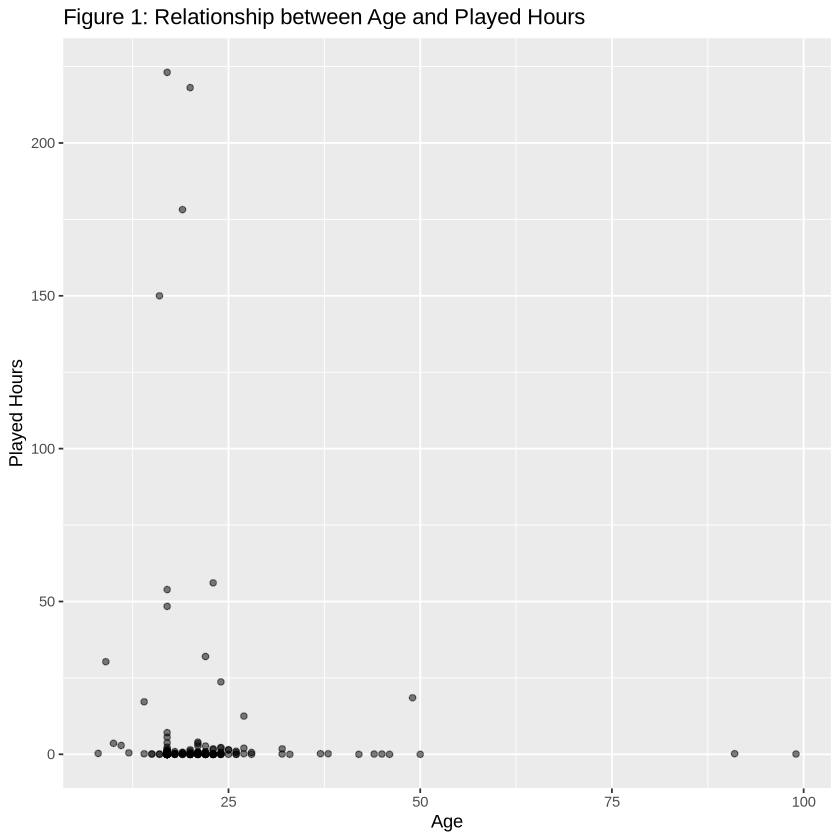

In [12]:
age_plot <- ggplot(players, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.5) +
  labs(
    x = "Age",
    y = "Played Hours",
    title = "Figure 1: Relationship between Age and Played Hours"
  ) 
age_plot

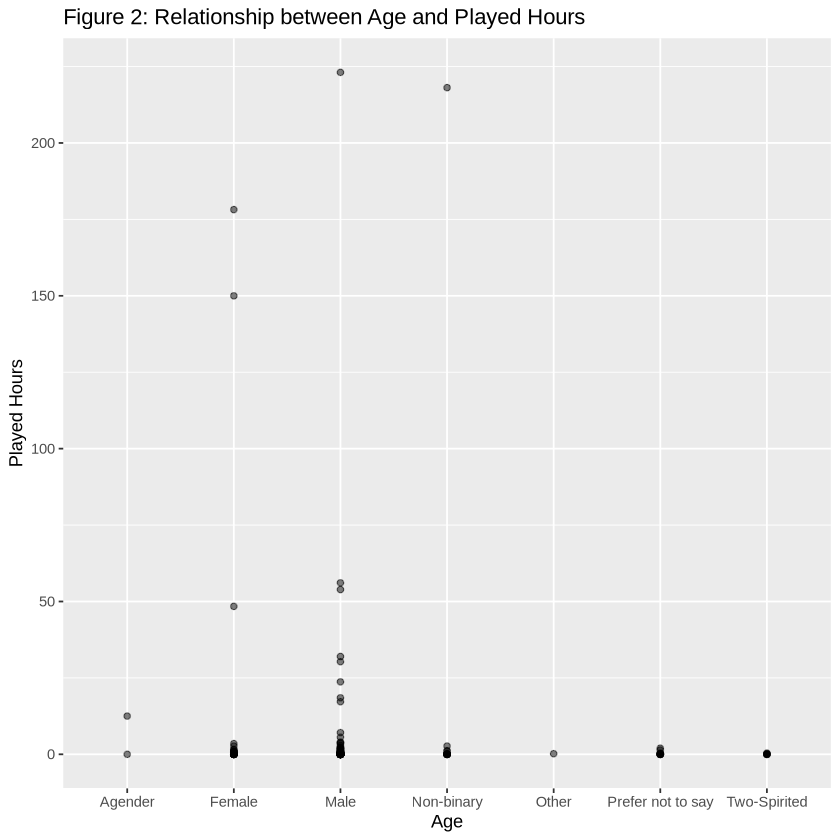

In [25]:
gender_plot <- ggplot(players, aes(x = gender, y = played_hours)) +
  geom_point(alpha = 0.5) +
  labs(
    x = "Age",
    y = "Played Hours",
    title = "Figure 2: Relationship between Age and Played Hours"
  ) 
gender_plot

Based on the scatter plots, there is no observable relationship between gender or age and played_hours. Therefore, these variables can be excluded from the explanatory variables.

### 2.2 Modal Training

In [14]:
combined_data <- players |>
  select(-individualId, -organizationName, -name, -age, -gender) |>
  left_join(sessions_by_player, by = "hashedEmail") |>
  mutate(
    total_sessions = replace_na(total_sessions, 0),
    unique_days = replace_na(unique_days, 0),
    subscribe_num = as.numeric(subscribe),
    experience = factor(experience)
  )
head(combined_data)

experience,subscribe,hashedEmail,played_hours,total_sessions,unique_days,subscribe_num
<fct>,<lgl>,<chr>,<dbl>,<int>,<int>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,27,18,1
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,3,2,1
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,1,1,0
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,1,1,1
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,1,1,1
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,0,0,1


In [15]:
set.seed(999) #DON'T CHANGE

data_split <- initial_split(combined_data, prop = 0.8)
train_data <- training(data_split)
test_data <- testing(data_split)

In [16]:
player_vfold <- vfold_cv(train_data, v = 5)

player_recipe <- recipe(played_hours ~ total_sessions + unique_days + experience + subscribe_num, 
                       data = train_data) |>
  step_dummy(all_nominal_predictors()) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

player_spec <- nearest_neighbor(weight_func = "rectangular",
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

gridvals <- tibble(neighbors = seq(1, 50)) 

player_multi <- workflow()|>
  add_recipe(player_recipe) |>
  add_model(player_spec) |>
  tune_grid(player_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse") |>
  filter(mean == min(mean))

player_k <- player_multi |>
  pull(neighbors)

player_multi

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,rmse,standard,6.718016,5,1.265092,Preprocessor1_Model02


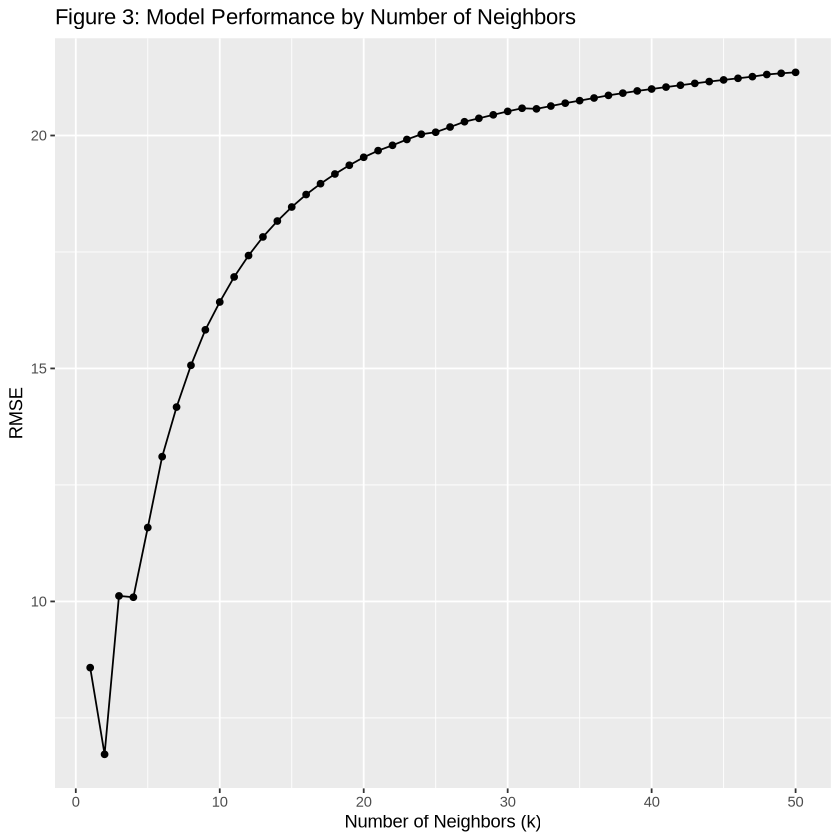

In [26]:
workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_spec) |>
  tune_grid(player_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse") |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(title = "Figure 3: Model Performance by Number of Neighbors",
       x = "Number of Neighbors (k)",
       y = "RMSE")

Here we see that the smallest estimated RMSPE from cross-validation occurs when K = 2.

In [18]:
final_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = player_k) |>
  set_engine("kknn") |>
  set_mode("regression")

knn_mult_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(final_spec) |>
  fit(data = train_data)

knn_mult_preds <- knn_mult_fit |>
  predict(test_data) |>
  bind_cols(test_data)

knn_mult_mets <- metrics(knn_mult_preds, 
                        truth = played_hours, 
                        estimate = .pred)

knn_mult_mets

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,27.9444605
rsq,standard,0.4415564
mae,standard,7.9825000


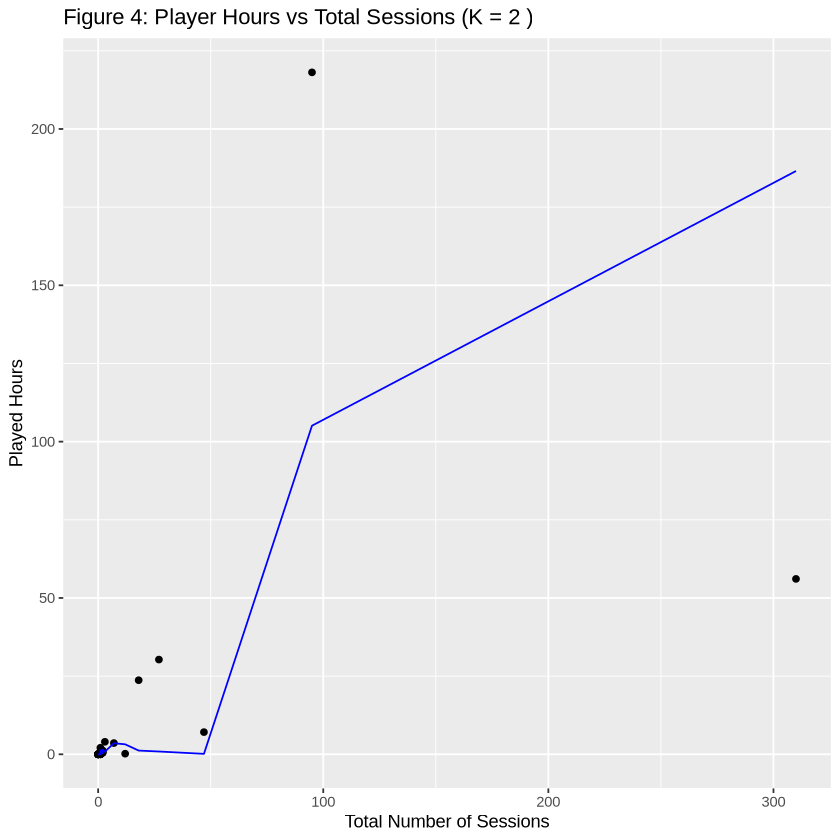

In [27]:
player_preds <- knn_mult_fit |>
  predict(test_data) |>
  bind_cols(test_data)

player_session_plot <- ggplot(player_preds, aes(x = total_sessions)) +
  geom_point(aes(y = played_hours)) +
  geom_line(aes(y = .pred), color = "blue") +
  labs(
    x = "Total Number of Sessions",
    y = "Played Hours",
    title = paste("Figure 4: Player Hours vs Total Sessions (K =", player_k, ")")
  )

player_session_plot

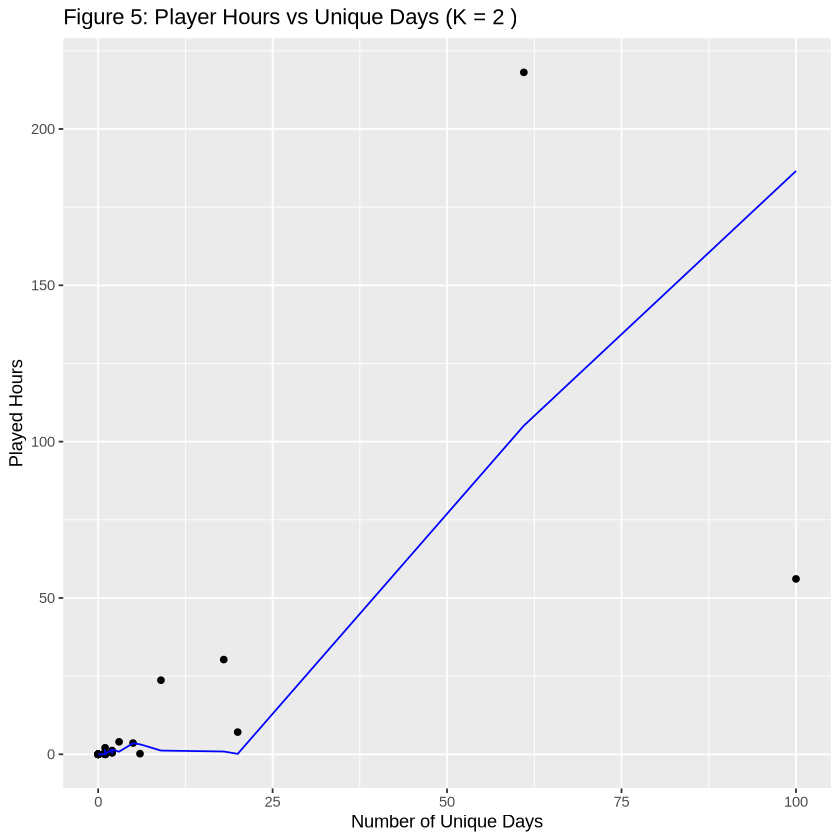

In [28]:
unique_days_plot <- ggplot(player_preds, aes(x = unique_days)) +
  geom_point(aes(y = played_hours)) +
  geom_line(aes(y = .pred), color = "blue") +
  labs(
    x = "Number of Unique Days",
    y = "Played Hours",
    title = paste("Figure 5: Player Hours vs Unique Days (K =", player_k, ")")
  )
unique_days_plot

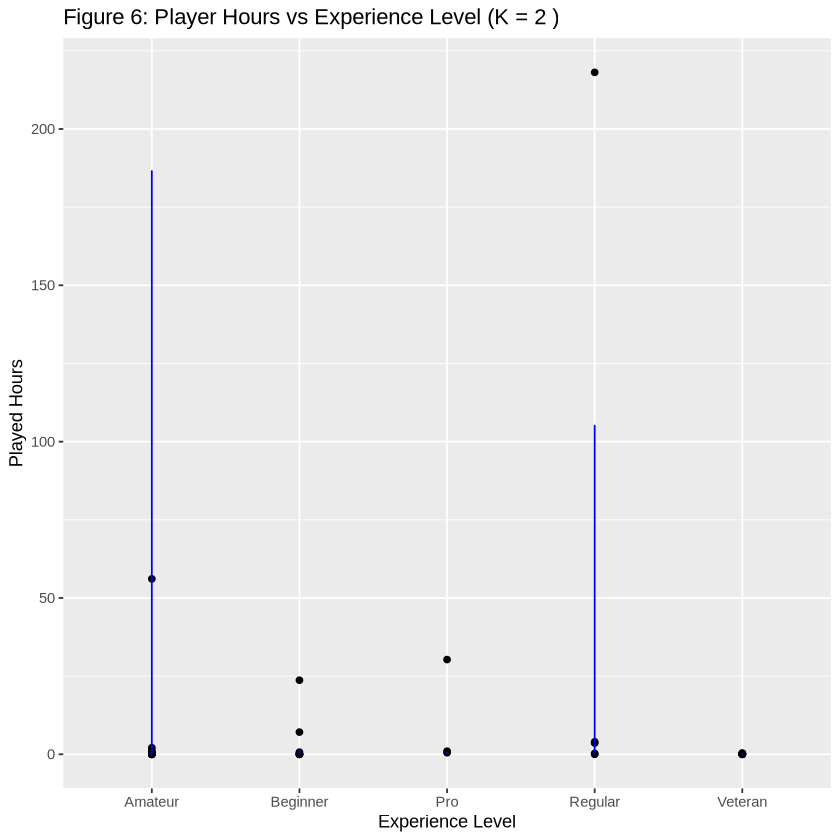

In [29]:
experience_plot <- ggplot(player_preds, aes(x = experience)) +
  geom_point(aes(y = played_hours)) +
  geom_line(aes(y = .pred), color = "blue") +
  labs(
    x = "Experience Level",
    y = "Played Hours",
    title = paste("Figure 6: Player Hours vs Experience Level (K =", player_k, ")")
  )
experience_plot

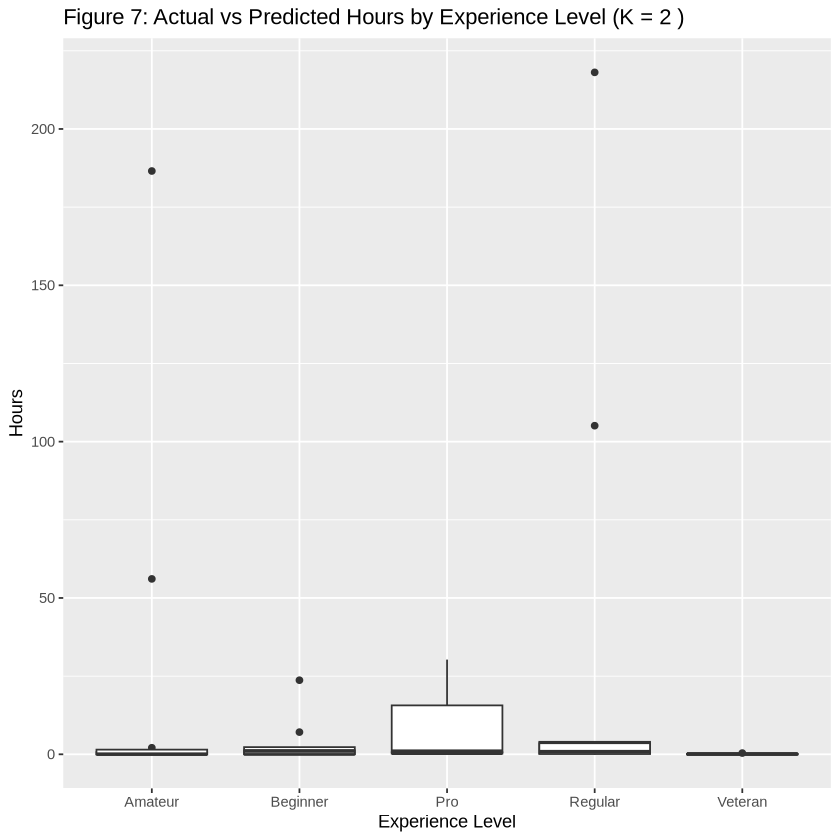

In [30]:
experience_eval <- ggplot(player_preds, aes(x = experience)) +
  geom_boxplot(aes(y = played_hours)) +
  geom_boxplot(aes(y = .pred)) +
  labs(
    x = "Experience Level",
    y = "Hours",
    title = paste("Figure 7: Actual vs Predicted Hours by Experience Level (K =", player_k, ")")
  ) 

experience_eval

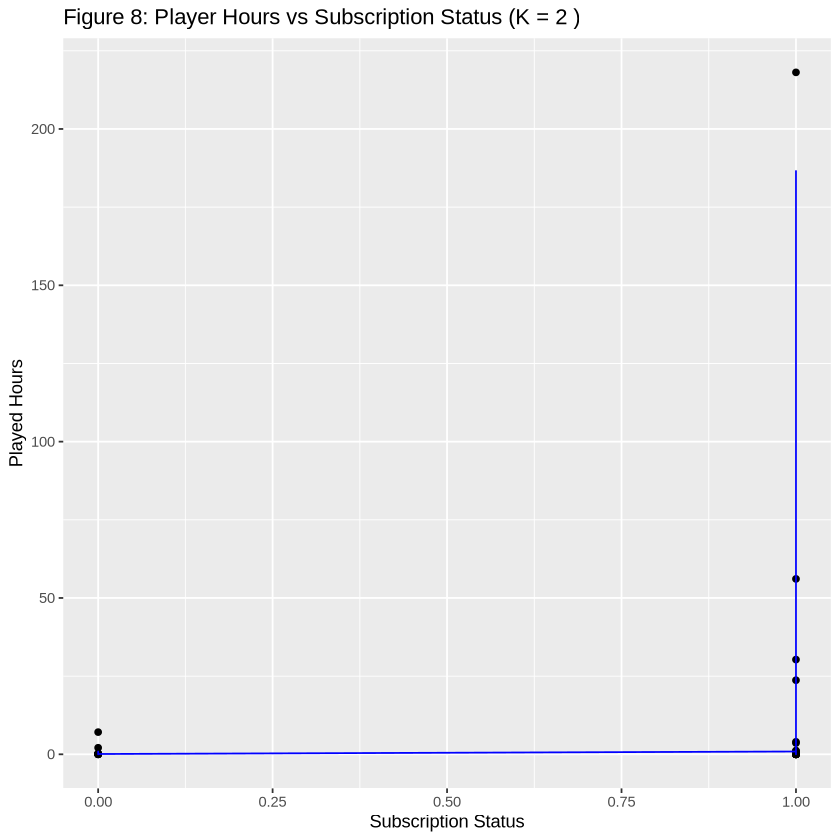

In [31]:
subscribe_plot <- ggplot(player_preds, aes(x = subscribe_num)) +
  geom_point(aes(y = played_hours)) +
  geom_line(aes(y = .pred), color = "blue") +
  labs(
    x = "Subscription Status",
    y = "Played Hours",
    title = paste("Figure 8: Player Hours vs Subscription Status (K =", player_k, ")")
  )
subscribe_plot

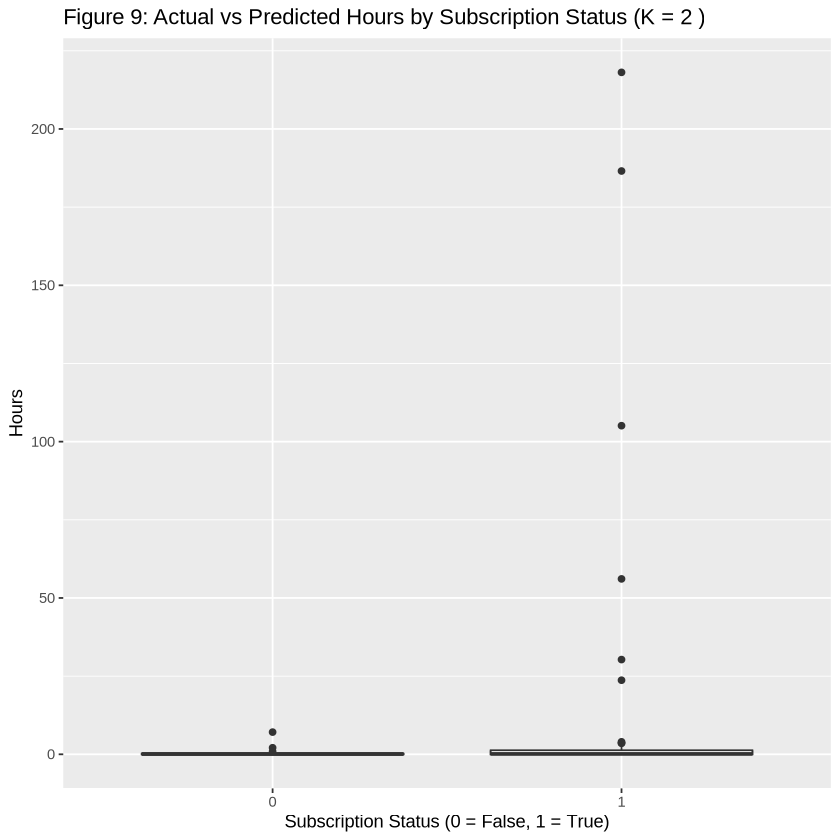

In [32]:
subscribe_eval <- ggplot(player_preds, aes(x = factor(subscribe_num))) +
  geom_boxplot(aes(y = played_hours)) +
  geom_boxplot(aes(y = .pred)) +
  labs(
    x = "Subscription Status (0 = False, 1 = True)",
    y = "Hours",
    title = paste("Figure 9: Actual vs Predicted Hours by Subscription Status (K =", player_k, ")")
  ) 
subscribe_eval